In [19]:
%pip install pandas numpy matplotlib scikit-learn imbalanced-learn joblib


Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    average_precision_score,
    roc_auc_score
)


In [21]:
df = pd.read_csv("../data/raw/creditcard.csv")
df.shape, df["Class"].value_counts()


((284807, 31),
 Class
 0    284315
 1       492
 Name: count, dtype: int64)

In [22]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [23]:
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

logreg_pipe.fit(X_train, y_train)


/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_fea

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [24]:
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("Confusion matrix (LR, thr=0.5):\n", confusion_matrix(y_test, y_pred_lr))
print("\nReport:\n", classification_report(y_test, y_pred_lr, digits=4))
print("\nPR-AUC:", average_precision_score(y_test, y_proba_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Confusion matrix (LR, thr=0.5):
 [[55478  1386]
 [    8    90]]

Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962


PR-AUC: 0.7189705771419241
ROC-AUC: 0.9720834996210077


/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

def eval_threshold(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    print(f"\n==============================")
    print(f"Threshold = {thr:.2f}")
    print("==============================")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nReport:\n", classification_report(y_true, y_pred, digits=4))

thresholds = [0.50, 0.40, 0.35, 0.30, 0.20, 0.10, 0.05]

for thr in thresholds:
    eval_threshold(y_test, y_proba_lr, thr)

print("\nNOTE: PR-AUC is threshold-independent:")
print("PR-AUC:", average_precision_score(y_test, y_proba_lr))




Threshold = 0.50
Confusion matrix:
 [[55478  1386]
 [    8    90]]

Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962


Threshold = 0.40
Confusion matrix:
 [[54819  2045]
 [    8    90]]

Report:
               precision    recall  f1-score   support

           0     0.9999    0.9640    0.9816     56864
           1     0.0422    0.9184    0.0806        98

    accuracy                         0.9640     56962
   macro avg     0.5210    0.9412    0.5311     56962
weighted avg     0.9982    0.9640    0.9801     56962


Threshold = 0.35
Confusion matrix:
 [[54328  2536]
 [    8    90]]

Report:
               precision    recall  f1-score   support

           0     0.9999    0.9554    0.9771     56864
   

In [26]:
coef = logreg_pipe.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("coef", ascending=False)

coef_df.head(10), coef_df.tail(10)


(   feature      coef  odds_ratio
 29  Amount  2.367276   10.668290
 1       V1  1.723862    5.606139
 4       V4  1.339431    3.816870
 5       V5  1.214379    3.368201
 2       V2  0.932075    2.539775
 22     V22  0.602374    1.826450
 11     V11  0.518715    1.679868
 3       V3  0.505718    1.658176
 28     V28  0.338464    1.402791
 23     V23  0.308435    1.361293,
    feature      coef  odds_ratio
 9       V9 -0.529469    0.588917
 8       V8 -0.583326    0.558039
 6       V6 -0.696494    0.498329
 7       V7 -0.833570    0.434495
 20     V20 -0.927469    0.395554
 17     V17 -0.992185    0.370766
 16     V16 -0.996376    0.369215
 12     V12 -1.127886    0.323717
 10     V10 -1.334996    0.263159
 14     V14 -1.494961    0.224257)

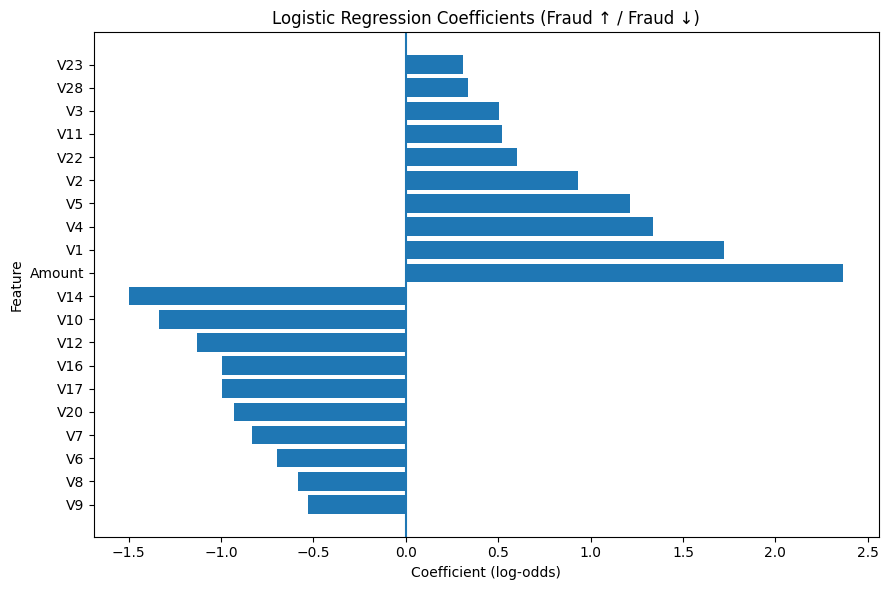

In [27]:
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)
plot_df = pd.concat([top_neg, top_pos])

plt.figure(figsize=(9, 6))
plt.barh(plot_df["feature"], plot_df["coef"])
plt.axvline(0)
plt.title("Logistic Regression Coefficients (Fraud ↑ / Fraud ↓)")
plt.xlabel("Coefficient (log-odds)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


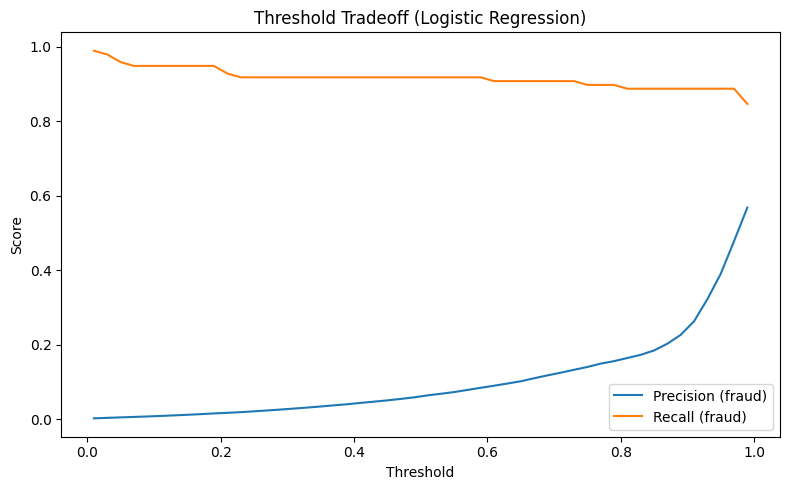

In [28]:
thresholds = np.linspace(0.01, 0.99, 50)
precisions, recalls = [], []

for thr in thresholds:
    y_pred = (y_proba_lr >= thr).astype(int)
    report = classification_report(
        y_test, y_pred, output_dict=True, zero_division=0
    )
    precisions.append(report["1"]["precision"])
    recalls.append(report["1"]["recall"])

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision (fraud)")
plt.plot(thresholds, recalls, label="Recall (fraud)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tradeoff (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote_pipe = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

smote_pipe.fit(X_train, y_train)


/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklea

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [30]:
y_proba_smote = smote_pipe.predict_proba(X_test)[:, 1]
y_pred_smote = (y_proba_smote >= 0.5).astype(int)

print("Confusion matrix (SMOTE, thr=0.5):\n",
      confusion_matrix(y_test, y_pred_smote))
print("\nReport:\n", classification_report(y_test, y_pred_smote, digits=4))
print("\nPR-AUC (SMOTE):",
      average_precision_score(y_test, y_proba_smote))
print("ROC-AUC (SMOTE):",
      roc_auc_score(y_test, y_proba_smote))


Confusion matrix (SMOTE, thr=0.5):
 [[55397  1467]
 [    8    90]]

Report:
               precision    recall  f1-score   support

           0     0.9999    0.9742    0.9869     56864
           1     0.0578    0.9184    0.1088        98

    accuracy                         0.9741     56962
   macro avg     0.5288    0.9463    0.5478     56962
weighted avg     0.9982    0.9741    0.9854     56962


PR-AUC (SMOTE): 0.7244694356694709
ROC-AUC (SMOTE): 0.9708434302252134


/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/willgan/fraud_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [31]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [32]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print("Confusion matrix (RF, thr=0.5):\n",
      confusion_matrix(y_test, y_pred_rf))
print("\nReport:\n", classification_report(y_test, y_pred_rf, digits=4))
print("\nPR-AUC (RF):",
      average_precision_score(y_test, y_proba_rf))
print("ROC-AUC (RF):",
      roc_auc_score(y_test, y_proba_rf))


Confusion matrix (RF, thr=0.5):
 [[56861     3]
 [   24    74]]

Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9610    0.7551    0.8457        98

    accuracy                         0.9995     56962
   macro avg     0.9803    0.8775    0.9227     56962
weighted avg     0.9995    0.9995    0.9995     56962


PR-AUC (RF): 0.8596719872389349
ROC-AUC (RF): 0.9571772751025001


In [33]:
import joblib
from pathlib import Path

Path("../models").mkdir(exist_ok=True)

joblib.dump(logreg_pipe, "../models/logreg_classweight.joblib")
joblib.dump(smote_pipe, "../models/logreg_smote.joblib")
joblib.dump(rf, "../models/random_forest_classweight.joblib")

print("Models saved to ../models/")


Models saved to ../models/
